<a href="https://colab.research.google.com/github/AaqibZ/AaqibZ/blob/main/IM_Using_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -r requirement.txt


  Using cached dgl-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (553 bytes)
  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-m

In [9]:
import networkx as nx
import random
import os

In [10]:
import networkx as nx
import os
import random
import pickle   # <-- added

def generate_dynamic_endo_syni(num_initial_nodes=50, num_snapshots=10, num_final_nodes=500, edges_per_snapshot=20, output_dir="dynamic_endo_syni"):
    """
    Generate a dynamic Endo-Syni graph with expansion over multiple snapshots.

    Args:
        num_initial_nodes (int): Number of nodes in the initial graph.
        num_snapshots (int): Number of snapshots to generate.
        num_final_nodes (int): Total number of nodes by the final snapshot.
        edges_per_snapshot (int): Number of edges to add in each snapshot.
        output_dir (str): Directory to save snapshots as Pickle files.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize the graph with a small number of nodes and edges
    G = nx.Graph()
    G.add_nodes_from(range(num_initial_nodes))
    for _ in range(num_initial_nodes // 2):
        u, v = random.sample(range(num_initial_nodes), 2)
        G.add_edge(u, v)

    # Save the initial snapshot
    filename = os.path.join(output_dir, "snapshot_0.pkl")
    with open(filename, "wb") as f:
        pickle.dump(G, f)
    print(f"Snapshot 0 saved: Nodes = {G.number_of_nodes()}, Edges = {G.number_of_edges()}")

    # Incrementally expand the graph
    for snapshot in range(1, num_snapshots):
        # Add new nodes
        current_nodes = G.number_of_nodes()
        new_nodes = int(num_initial_nodes + (num_final_nodes - num_initial_nodes) * snapshot / (num_snapshots - 1))
        for node in range(current_nodes, new_nodes):
            G.add_node(node)

        # Add edges based on Endo-Syni dynamics
        for _ in range(edges_per_snapshot):
            # Endogenous growth: Preferential attachment (connect to high-degree nodes)
            u = random.choices(list(G.nodes), weights=dict(G.degree).values(), k=1)[0]
            v = random.choice(list(G.nodes))
            if u != v and not G.has_edge(u, v):
                G.add_edge(u, v)

            # Synergistic dynamics: Connect hubs to each other
            hubs = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]  # Top 10 hubs
            if len(hubs) >= 2:
                hub_u, hub_v = random.sample([hub[0] for hub in hubs], 2)
                if not G.has_edge(hub_u, hub_v):
                    G.add_edge(hub_u, hub_v)

        # Save the snapshot
        filename = os.path.join(output_dir, f"snapshot_{snapshot}.pkl")
        try:
            with open(filename, "wb") as f:
                pickle.dump(G, f)
            print(f"Snapshot {snapshot} saved: Nodes = {G.number_of_nodes()}, Edges = {G.number_of_edges()}")
        except Exception as e:
            print(f"Error saving snapshot {snapshot}: {e}")


In [11]:
output_dir = "/content/endo_syni_snapshots_1000/"

# make sure the directory exists
import os
os.makedirs(output_dir, exist_ok=True)

# Generate a dynamic Endo-Syni graph
generate_dynamic_endo_syni(
    num_initial_nodes=500,
    num_snapshots=13,
    num_final_nodes=1000,
    edges_per_snapshot=50,
    output_dir=output_dir
)


Snapshot 0 saved: Nodes = 500, Edges = 250
Snapshot 1 saved: Nodes = 541, Edges = 329
Snapshot 2 saved: Nodes = 583, Edges = 385
Snapshot 3 saved: Nodes = 625, Edges = 439
Snapshot 4 saved: Nodes = 666, Edges = 489
Snapshot 5 saved: Nodes = 708, Edges = 539
Snapshot 6 saved: Nodes = 750, Edges = 589
Snapshot 7 saved: Nodes = 791, Edges = 638
Snapshot 8 saved: Nodes = 833, Edges = 688
Snapshot 9 saved: Nodes = 875, Edges = 738
Snapshot 10 saved: Nodes = 916, Edges = 787
Snapshot 11 saved: Nodes = 958, Edges = 842
Snapshot 12 saved: Nodes = 1000, Edges = 894


In [12]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [13]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


class GraphProcessor:
    def __init__(self, input_dir=None, output_dir=None, uniinfweight=1.0):
        """
        Initialize the GraphProcessor class.

        Parameters:
            input_dir (str): Directory containing input graphs (optional).
            output_dir (str): Directory to save processed graphs (optional).
        """
        self.uniinfweight = uniinfweight
        self.input_dir = input_dir
        self.output_dir = output_dir

    def calculate_ifc_score(self, G):
        nodelist = list(G.nodes)
        il = {}  # Local influence scores
        ig = {}  # Global influence scores

        degn = len(nodelist)

        for countnode, node in enumerate(nodelist):
            tempw = 0
            for neighbnode in G.neighbors(node):
                tempw += self.uniinfweight * self.uniinfweight * nx.degree(G, neighbnode)

            # Local score
            il[node] = 1 + list(G.degree([node], weight='weight'))[0][1] + tempw

            # Global score
            ig[node] = nx.core_number(G)[node] * (
                1 + (nx.degree(G, node)) / degn
            )

        # Combine local and global scores into a tuple
        ifc_scores = {node: (il[node], ig[node]) for node in nodelist}

        return ifc_scores


    def add_features_to_graph(self, G):
        # Calculate graph metrics
        degree = dict(G.degree())
        betweenness = nx.betweenness_centrality(G)
        k_core = nx.core_number(G)
        avg_neighbor_degree = nx.average_neighbor_degree(G)
        ifc_scores = self.calculate_ifc_score(G)

        # Add features to nodes
        for node in G.nodes:
            if node not in ifc_scores or len(ifc_scores[node]) < 1:
                print(f"Skipping node {node}: IFC scores missing or invalid")
                continue  # Skip this node if IFC scores are not valid

            # Add features
            G.nodes[node]["features"] = [
                degree[node],
                betweenness[node],
                k_core[node],
                avg_neighbor_degree[node],
                ifc_scores[node][0],  # Local influence score
            ]

        return G

    def add_labels_to_graph(self, G, top_percentage=40):
        """
        Add labels to ensure exactly `top_percentage` of nodes are labeled `1` based on IFC score.

        Parameters:
            G (networkx.Graph): The graph object.
            top_percentage (float): Percentage of nodes to label as `1` (default is 30%).

        Returns:
            networkx.Graph: The graph with labeled nodes.
        """
        # Extract IFC scores and sort nodes by IFC score in descending order
        nodes_with_scores = [(node, G.nodes[node]["features"][-1]) for node in G.nodes]
        sorted_nodes = sorted(nodes_with_scores, key=lambda x: x[1], reverse=True)

        # Determine the number of nodes to label as `1`
        num_top_nodes = int(len(sorted_nodes) * top_percentage / 100)

        # Label top `num_top_nodes` as `1` and the rest as `0`
        for i, (node, _) in enumerate(sorted_nodes):
            G.nodes[node]["label"] = 1 if i < num_top_nodes else 0

        return G

    def process_graphs(self):
        """
        Process all graphs in the input directory:
        - Add features
        - Add labels
        - Save the modified graphs
        """
        for file_name in os.listdir(self.input_dir):
            if file_name.endswith(".gpickle"):
                graph_path = os.path.join(self.input_dir, file_name)

                # Load the graph
                G = nx.read_gpickle(graph_path)

                # Add features and labels
                G = self.add_features_to_graph(G)
                G = self.add_labels_to_graph(G)

                # Save the modified graph
                output_path = os.path.join(self.output_dir, file_name)
                nx.write_gpickle(G, output_path)
                print(f"Processed and saved graph: {output_path}")

In [14]:
import numpy as np
import time

class InfluenceMaximization:
    def __init__(self, graph, propagation_probability=0.5, monte_carlo=10):
        """
        Initialize the Influence Maximization class.

        Parameters:
            graph (networkx.Graph): The graph object.
            propagation_probability (float): Propagation probability.
            monte_carlo (int): Number of Monte Carlo simulations.
        """
        self.graph = graph
        self.p = propagation_probability
        self.mc = monte_carlo

    def influence_spread(self, S):
        """
        Calculate the influence spread using the Independent Cascade (IC) model.

        Parameters:
            S (list): Set of seed nodes.

        Returns:
            float: Average number of nodes influenced by the seed nodes.
        """
        spread = []  # Store the spread for each Monte Carlo simulation

        for i in range(self.mc):
            # Simulate the propagation process
            new_active, A = S[:], S[:]  # Initialize active nodes

            while new_active:
                new_ones = []
                for node in new_active:
                    # Randomly activate neighbors based on propagation probability
                    np.random.seed(i)
                    neighbors = list(self.graph.neighbors(node))
                    success = np.random.uniform(0, 1, len(neighbors)) < self.p
                    new_ones += list(np.extract(success, neighbors))

                # Deduplicate and find newly activated nodes
                new_active = list(set(new_ones) - set(A))
                A += new_active  # Add newly activated nodes to the influenced set

            spread.append(len(A))  # Store the total spread for this simulation

        return np.mean(spread)  # Average spread over all simulations

    def greedy(self, k):
        """
        Greedy algorithm for influence maximization.

        Parameters:
            k (int): Number of seed nodes to select.

        Returns:
            tuple: (optimal seed set, resulting spread, elapsed time per iteration)
        """
        S, spread, timelapse = [], [], []
        start_time = time.time()

        for _ in range(k):
            best_spread = 0
            for j in set(self.graph.nodes()) - set(S):
                # Calculate the spread if j is added to the seed set
                s = self.influence_spread(S + [j])
                if s > best_spread:
                    best_spread, node = s, j

            # Add the selected node to the seed set
            S.append(node)
            spread.append(best_spread)
            timelapse.append(time.time() - start_time)

        return S, spread, timelapse

    def greedy_mod(self, k, candidatenodelist):
        """
        Heuristic-based greedy algorithm for influence maximization.

        Parameters:
            k (int): Number of seed nodes to select.
            candidatenodelist (list): List of candidate nodes for seeding.

        Returns:
            tuple: (heuristic seed set, resulting spread, elapsed time per iteration)
        """
        S, spread, timelapse = [], [], []
        start_time = time.time()

        for _ in range(k):
            best_spread = 0
            for j in set(candidatenodelist) - set(S):
                # Calculate the spread if j is added to the seed set
                s = self.influence_spread(S + [j])
                if s > best_spread:
                    best_spread, node = s, j

            # Add the selected node to the seed set
            S.append(node)
            spread.append(best_spread)
            timelapse.append(time.time() - start_time)

        return S, spread, timelapse

In [15]:
#Create Dynamic Graph
import sys
import os
os.path.join(os.getcwd())
import matplotlib; print(matplotlib.__version__)
import pandas as pd
import numpy as np
import networkx as nx
from datetime import date, timedelta
import networkx as nx
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

3.10.0


In [16]:
#IMutil
import pandas as pd
import numpy as np
import networkx as nx
from datetime import date, timedelta
import networkx as nx
from matplotlib import pyplot as plt
import pandas as pd


class IMutil():
    def __init__(self):
        print("IM hep class is invoked")

    # # get IFC centrality score for each node
    # def get_inflcapapcity(self, g, uniinfweight):
    #     nodelist = list(g.nodes)
    #     il = np.zeros((len(nodelist), 1))
    #     ig = np.zeros((len(nodelist), 1))

    #     degn = max([nx.degree(g, ind) for ind in g.nodes])

    #     for countnode in range(len(nodelist)):
    #         tempw = 0
    #         for neighbnode in g.neighbors(nodelist[countnode]):
    #             tempw = tempw + uniinfweight * uniinfweight * nx.degree(g, neighbnode)

    #         # local score
    #         il[nodelist[countnode]] = 1 + list(g.degree([nodelist[countnode]], weight='weight'))[0][1] + tempw

    #         # global score
    #         ig[nodelist[countnode]] = nx.core_number(g)[nodelist[countnode]] * (
    #                     1 + (nx.degree(g, nodelist[countnode])) / (degn))

    #     # overall score
    #     ic = np.array([(il[nodelist[countnode]] / np.max(il)) * (ig[nodelist[countnode]] / np.max(ig)) for countnode in
    #                    range(len(nodelist))])

    #     return ic

    def calculate_ifc_score(G, uniinfweight=1.0):
        """
        Calculate the Influence Capacity (IFC) score for each node in the graph.

        Parameters:
            G (networkx.Graph): Input graph.
            uniinfweight (float): Weight factor for influence score calculation.

        Returns:
            dict: A dictionary mapping nodes to their IFC scores.
        """
        nodelist = list(G.nodes)
        il = np.zeros(len(nodelist))  # Local influence scores
        ig = np.zeros(len(nodelist))  # Global influence scores

        degn = max(dict(G.degree()).values())  # Maximum degree for normalization

        for idx, node in enumerate(nodelist):
            # Calculate local influence
            tempw = sum(uniinfweight * G.degree(neighb) for neighb in G.neighbors(node))
            il[idx] = 1 + G.degree(node) + tempw

            # Calculate global influence
            ig[idx] = nx.core_number(G)[node] * (1 + G.degree(node) / degn)

        # Normalize and calculate overall IFC score
        il_norm = il / np.max(il) if np.max(il) > 0 else il
        ig_norm = ig / np.max(ig) if np.max(ig) > 0 else ig
        ic_scores = il_norm * ig_norm

        return {node: ic_scores[idx] for idx, node in enumerate(nodelist)}


In [17]:
# Download and unzip
!wget -q https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz -O /content/soc-sign-bitcoinalpha.csv.gz
!gunzip -f /content/soc-sign-bitcoinalpha.csv.gz

# Check file
!ls -lh /content/soc-sign-bitcoinalpha.csv


-rw-r--r-- 1 root root 492K Oct  6  2017 /content/soc-sign-bitcoinalpha.csv


In [18]:
!wget -q https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz -O /content/email-Eu-core-temporal.txt.gz
!gunzip -f /content/email-Eu-core-temporal.txt.gz

!ls -lh /content/email-Eu-core-temporal.txt


-rw-r--r-- 1 root root 5.3M Jun  5  2017 /content/email-Eu-core-temporal.txt


In [19]:
import sys
import os
os.path.join(os.getcwd())
import matplotlib; print(matplotlib.__version__)
import pandas as pd
import numpy as np
import networkx as nx
from datetime import date, timedelta
import networkx as nx
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

3.10.0


In [20]:
# ✅ Step 3: Read the dataset
df = pd.read_csv("soc-sign-bitcoinalpha.csv", header=None)

# Show first 5 rows
df.head()


,0,1,2,3
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400


In [21]:
# ✅ Step 4: Rename the columns for clarity
df.rename(columns={0: "source", 1: "target", 2: "rating", 3: "timestamp"}, inplace=True)

# Show first 5 rows after renaming
df.head()


,source,target,rating,timestamp
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400


In [22]:
# ✅ Step 5: Show dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24186 entries, 0 to 24185
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   source     24186 non-null  int64
 1   target     24186 non-null  int64
 2   rating     24186 non-null  int64
 3   timestamp  24186 non-null  int64
dtypes: int64(4)
memory usage: 755.9 KB


In [23]:
# Drop duplicate edges based on source and target (keep first occurrence)
df = df.drop_duplicates(
    subset=['source', 'target'],
    keep='first'
).reset_index(drop=True)

# Convert unix timestamp to pandas datetime
df['date'] = pd.to_datetime(df['timestamp'], unit="s")

# Show dataframe with new datetime column
df['date']


,date
0,2014-08-08 04:00:00
1,2013-08-15 04:00:00
2,2013-05-28 04:00:00
3,2012-10-12 04:00:00
4,2012-09-17 04:00:00
...,...
24181,2013-03-26 04:00:00
24182,2013-03-26 04:00:00
24183,2013-03-26 04:00:00
24184,2013-03-26 04:00:00


In [24]:
# Grouping by year and month from the 'date' column
grouped = df.groupby([df['date'].dt.year, df['date'].dt.month])

# Display group sizes
grouped.size()


date  date
2010  11       41
      12       57
2011  1        67
      2       188
      3       175
             ... 
2015  9        25
      10       20
      11        9
      12       38
2016  1        17
Length: 63, dtype: int64

In [25]:
grouped

In [26]:
# Access the last group
last_group = grouped.get_group(max(grouped.groups))
last_group

,source,target,rating,timestamp,date
5252,3447,15,3,1451797200,2016-01-03 05:00:00
5382,15,3451,1,1453438800,2016-01-22 05:00:00
5383,15,2437,1,1452834000,2016-01-15 05:00:00
5384,15,3443,1,1452747600,2016-01-14 05:00:00
5385,15,3448,1,1452747600,2016-01-14 05:00:00
5386,15,1396,1,1452488400,2016-01-11 05:00:00
11202,953,64,3,1452315600,2016-01-09 05:00:00
13594,3451,98,5,1453438800,2016-01-22 05:00:00
13889,104,2437,1,1452834000,2016-01-15 05:00:00
14393,114,7370,-1,1453006800,2016-01-17 05:00:00


In [27]:
# Filter rows where the year is 2026
df_2016 = df[df['date'].dt.year == 2016]

In [28]:
df_2016

,source,target,rating,timestamp,date
5252,3447,15,3,1451797200,2016-01-03 05:00:00
5382,15,3451,1,1453438800,2016-01-22 05:00:00
5383,15,2437,1,1452834000,2016-01-15 05:00:00
5384,15,3443,1,1452747600,2016-01-14 05:00:00
5385,15,3448,1,1452747600,2016-01-14 05:00:00
5386,15,1396,1,1452488400,2016-01-11 05:00:00
11202,953,64,3,1452315600,2016-01-09 05:00:00
13594,3451,98,5,1453438800,2016-01-22 05:00:00
13889,104,2437,1,1452834000,2016-01-15 05:00:00
14393,114,7370,-1,1453006800,2016-01-17 05:00:00


In [29]:
# Find the minimum node number
min_node_number = min(df['source'].min(), df['target'].min())

min_node_number

# Subtract the minimum node number to shift node numbers to start from 0
# df['source'] -= min_node_number
# df['target'] -= min_node_number

1

In [30]:
#get maximum element from row & column to get the number of nodes
max_node = max(df['source'].max(),df['target'].max())
print("Maximum", max_node )

Maximum 7604


In [31]:
def graph_details(graph_dir):
    # Iterate over the gpickle files in the directory
    for file_name in os.listdir(graph_dir):
        if file_name.endswith('.gpickle'):
            # Construct the full file path
            file_path = os.path.join(graph_dir, file_name)

            # Load the graph from the gpickle file
            graph = nx.read_gpickle(file_path)

            # Get the number of nodes and edges
            num_nodes = graph.number_of_nodes()
            num_edges = graph.number_of_edges()

            # Print the number of nodes and edges
            print(f"Graph: {file_name}", "Number of nodes & edges :", num_nodes,  num_edges)
    return 1

In [38]:
import os
import networkx as nx
import pandas as pd
import pickle  # Use standard pickle for saving/loading graphs

# Assume 'grouped' is your grouped DataFrame
# grouped = df.groupby('timestamp')  # Example if not already defined

# Save all outputs in Colab's content directory
graph_dir = "/content/bit-coin-alpha"

# Create the directory if it doesn't exist
if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

previous_snapshot = nx.DiGraph()  # Initialize an empty directed graph for the previous snapshot

# Create a graph with nodes ranging from 0 to 7604
nodes = list(range(7605))
previous_snapshot.add_nodes_from(nodes)

count = 0
for timestamp, group in grouped:
    g = previous_snapshot.copy()  # Create a copy of the previous snapshot

    # Iterate through the DataFrame and add new edges with weight 1
    for index, row in group.iterrows():
        source = row['source']
        target = row['target']
        g.add_edge(source, target, weight=1)

    # Remove self-loops
    g.remove_edges_from(nx.selfloop_edges(g))

    # Save the graph as a gpickle file using pickle
    filename_gpickle = os.path.join(graph_dir, f"snapshot_{count}.gpickle")
    with open(filename_gpickle, 'wb') as f:
        pickle.dump(g, f)

    # Save the graph as an edgelist with weight=1
    filename_edgelist = os.path.join(graph_dir, f"snapshot_{count}.edgelist")
    nx.write_weighted_edgelist(g, filename_edgelist, delimiter=' ', comments='')

    count += 1
    # Update the previous snapshot to the current graph for the next iteration
    previous_snapshot = g

print(f"All snapshots saved in: {graph_dir}")


All snapshots saved in: /content/bit-coin-alpha


In [39]:
import os
import networkx as nx
import pandas as pd
import pickle  # For saving/loading graphs

# Save all outputs in Colab's content directory
graph_dir = "/content/bit-coin-alpha"

# Create the directory if it doesn't exist
if not os.path.exists(graph_dir):
    os.makedirs(graph_dir)

previous_snapshot = nx.DiGraph()  # Initialize an empty directed graph for the previous snapshot

# Create a graph with nodes ranging from 0 to 7603
nodes = list(range(7604))
previous_snapshot.add_nodes_from(nodes)

count = 0
for timestamp, group in grouped:  # 'grouped' should be your grouped DataFrame
    g = previous_snapshot.copy()  # Create a copy of the previous snapshot

    # Add new edges with weight 1
    for index, row in group.iterrows():
        source = row['source']
        target = row['target']
        g.add_edge(source, target, weight=1)

    # Remove self-loops
    g.remove_edges_from(nx.selfloop_edges(g))

    # Save the graph as a gpickle using pickle
    filename_gpickle = os.path.join(graph_dir, f"snapshot_{count}.gpickle")
    with open(filename_gpickle, 'wb') as f:
        pickle.dump(g, f)

    # Save the graph as an edgelist with weight=1
    filename_edgelist = os.path.join(graph_dir, f"snapshot_{count}.edgelist")
    nx.write_weighted_edgelist(g, filename_edgelist, delimiter=' ', comments='')

    count += 1
    # Update the previous snapshot for the next iteration
    previous_snapshot = g

print(f"All snapshots saved in: {graph_dir}")


All snapshots saved in: /content/bit-coin-alpha


In [40]:
timestamp

(np.int32(2016), np.int32(1))

In [41]:
graph_details(graph_dir)

Total snapshots found: 63

Snapshot 0: snapshot_0.gpickle
  Nodes: 7604
  Edges: 41
  Density: 0.000001
  Is Directed: True
----------------------------------------
Snapshot 1: snapshot_1.gpickle
  Nodes: 7604
  Edges: 98
  Density: 0.000002
  Is Directed: True
----------------------------------------
Snapshot 2: snapshot_10.gpickle
  Nodes: 7604
  Edges: 6721
  Density: 0.000116
  Is Directed: True
----------------------------------------
Snapshot 3: snapshot_11.gpickle
  Nodes: 7604
  Edges: 6977
  Density: 0.000121
  Is Directed: True
----------------------------------------
Snapshot 4: snapshot_12.gpickle
  Nodes: 7604
  Edges: 7273
  Density: 0.000126
  Is Directed: True
----------------------------------------
Snapshot 5: snapshot_13.gpickle
  Nodes: 7604
  Edges: 7701
  Density: 0.000133
  Is Directed: True
----------------------------------------
Snapshot 6: snapshot_14.gpickle
  Nodes: 7604
  Edges: 8089
  Density: 0.000140
  Is Directed: True
---------------------------------

In [42]:
# get IFC centrality score for each node
def get_influence_capacity_scores(g, uniinfweight):
    nodelist = list(g.nodes)
    il = np.zeros((len(nodelist), 1))
    ig = np.zeros((len(nodelist), 1))

    degn = max([nx.degree(g, ind) for ind in g.nodes])

    for countnode in range(len(nodelist)):
        tempw = 0
        for neighbnode in g.neighbors(nodelist[countnode]):
            tempw = tempw + uniinfweight * uniinfweight * nx.degree(g, neighbnode)

        # local score
        il[nodelist[countnode]] = 1 + list(g.degree([nodelist[countnode]], weight='weight'))[0][1] + tempw

        # global score
        ig[nodelist[countnode]] = nx.core_number(g)[nodelist[countnode]] * (
                    1 + (nx.degree(g, nodelist[countnode])) / (degn))

    # overall score
    ic = np.array([(il[nodelist[countnode]] / np.max(il)) * (ig[nodelist[countnode]] / np.max(ig)) for countnode in
                range(len(nodelist))])

    return ic.flatten(), nodelist

In [43]:
def add_features_and_labels_to_graphs(input_dir, output_dir, uniinfweight):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith('.gpickle'):
            graph_path = os.path.join(input_dir, file_name)
            G = nx.read_gpickle(graph_path)

            num_nodes, num_edges = G.number_of_nodes(), G.number_of_edges()
            print(f"{graph_path}: Nodes={num_nodes}, Edges={num_edges}")

            ic_scores, nodelist = get_influence_capacity_scores(G, uniinfweight)
            threshold = np.percentile(ic_scores, 70)

            for countnode, node in enumerate(nodelist):
                G.nodes[node]['feature'] = [nx.degree(G, node), nx.average_neighbor_degree(G, nodes=[node])[node], 1, 1, 1]
                G.nodes[node]['label'] = int(ic_scores[countnode] >= threshold)

            output_path = os.path.join(output_dir, file_name)
            nx.write_gpickle(G, output_path)
            print(f"Processed and saved: {output_path}")

In [44]:
import os
import networkx as nx
import pickle

# Define the function to add features and labels
def add_features_and_labels_to_graphs(input_dir, output_dir, uniinfweight=1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith('.gpickle'):
            file_path = os.path.join(input_dir, file_name)

            # Load the graph using pickle
            with open(file_path, 'rb') as f:
                G = pickle.load(f)

            # Example: add a node feature or label (adjust as needed)
            for node in G.nodes():
                G.nodes[node]['uniinfweight'] = uniinfweight

            # Save updated graph
            out_file_path = os.path.join(output_dir, file_name)
            with open(out_file_path, 'wb') as f:
                pickle.dump(G, f)

            # Optionally, also save as weighted edgelist
            edgelist_file = os.path.join(output_dir, file_name.replace('.gpickle', '.edgelist'))
            nx.write_weighted_edgelist(G, edgelist_file, delimiter=' ', comments='')

    print(f"All graphs with features/labels saved in: {output_dir}")


# Set Colab-friendly directories
input_directory = "/content/bit-coin-alpha"
out_graph_dir = "/content/bit-coin-alpha-labels-3"

# Call the function
add_features_and_labels_to_graphs(input_directory, out_graph_dir, uniinfweight=1)


All graphs with features/labels saved in: /content/bit-coin-alpha-labels-3


In [ ]:
# Specify the directory where you want to save the graphs in Colab
out_graph_dir = "/content/bit-coin-alpha-labels-3"
input_directory = "/content/bit-coin-alpha"

# Make sure the directories exist (Colab will create them if not)
import os
os.makedirs(out_graph_dir, exist_ok=True)
os.makedirs(input_directory, exist_ok=True)  # only needed if uploading files later

# Call the function to add features and labels to graphs and save them
add_features_and_labels_to_graphs(input_directory, out_graph_dir, uniinfweight=1)


/content/bit-coin-alpha/snapshot_549.gpickle: Nodes=7604, Edges=10502
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_549.gpickle
/content/bit-coin-alpha/snapshot_168.gpickle: Nodes=7604, Edges=2600
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_168.gpickle
/content/bit-coin-alpha/snapshot_396.gpickle: Nodes=7604, Edges=7791
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_396.gpickle
/content/bit-coin-alpha/snapshot_83.gpickle: Nodes=7604, Edges=330
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_83.gpickle
/content/bit-coin-alpha/snapshot_583.gpickle: Nodes=7604, Edges=11229
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_583.gpickle
/content/bit-coin-alpha/snapshot_98.gpickle: Nodes=7604, Edges=428
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_98.gpickle
/content/bit-coin-alpha/snapshot_410.gpickle: Nodes=7604, Edges=7967
Processed and saved: /content/bit-coin-alpha-labels-3/snapshot_410.gpic

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-44744793.py", line 11, in <cell line: 0>
    add_features_and_labels_to_graphs(input_directory, out_graph_dir, uniinfweight=1)
  File "/tmp/ipython-input-2380544915.py", line 22, in add_features_and_labels_to_graphs
    ic_scores, nodelist = get_influence_capacity_scores(G, uniinfweight)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3542533190.py", line 18, in get_influence_capacity_scores
    ig[nodelist[countnode]] = nx.core_number(g)[nodelist[countnode]] * (
                              ^^^^^^^^^^^^^^^^^
  File "<class 'networkx.utils.decorators.argmap'> compilation 10", line 4, in argmap_core_number_6
    import inspect
            ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/networkx/utils/backends

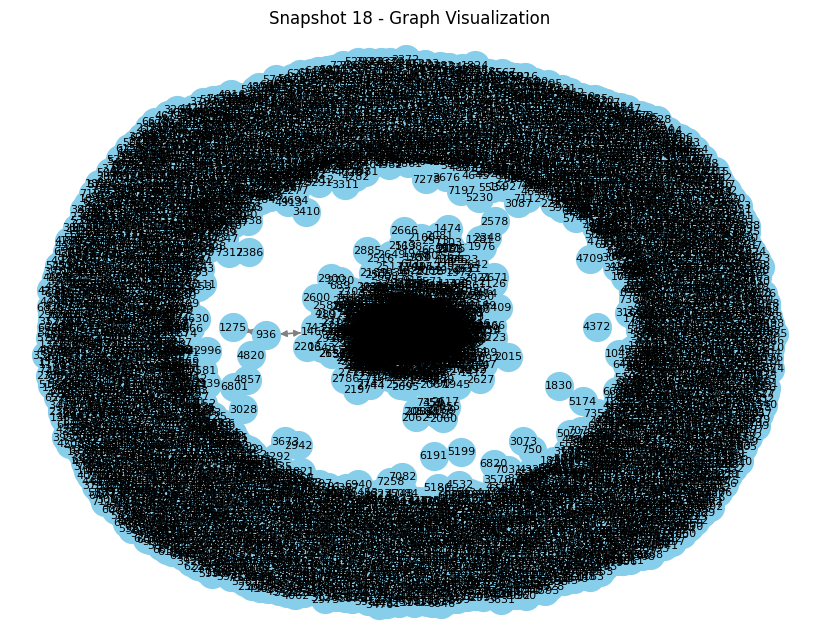


After adding features and labels (showing 1 node only):
0 {'uniinfweight': 1}

Number of nodes with label 1: 0


In [45]:
# === Run this in Colab ===

import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Your directories
out_graph_dir = "/content/bit-coin-alpha-labels-3"
input_directory = "/content/bit-coin-alpha"

# Load snapshot_18.gpickle from your output directory using pickle
g1_path = os.path.join(out_graph_dir, "snapshot_18.gpickle")
with open(g1_path, "rb") as f:
    g1 = pickle.load(f)

# --- Visualize the graph ---
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(g1, seed=42)  # reproducible layout
nx.draw(
    g1, pos, with_labels=True,
    node_color="skyblue", edge_color="gray",
    node_size=400, font_size=8
)
plt.title("Snapshot 18 - Graph Visualization")
plt.show()

# --- Print a sample node with features and labels ---
print("\nAfter adding features and labels (showing 1 node only):")
for node, data in g1.nodes(data=True):
    print(node, data)
    break

# --- Count nodes with label 1 ---
count_label_1 = sum(
    1 for _, node_data in g1.nodes(data=True)
    if node_data.get("label") == 1
)
print(f"\nNumber of nodes with label 1: {count_label_1}")


In [46]:
import os

# check directory contents
out_graph_dir = "/content/bit-coin-alpha-labels-3"

print("Does directory exist?", os.path.exists(out_graph_dir))
print("Files in directory:")
print(os.listdir(out_graph_dir)[:20])   # show first 20 files


Does directory exist? True
Files in directory:
['snapshot_19.gpickle', 'snapshot_52.gpickle', 'snapshot_34.edgelist', 'snapshot_22.edgelist', 'snapshot_46.gpickle', 'snapshot_43.edgelist', 'snapshot_51.gpickle', 'snapshot_9.edgelist', 'snapshot_56.gpickle', 'snapshot_28.edgelist', 'snapshot_18.gpickle', 'snapshot_24.edgelist', 'snapshot_41.edgelist', 'snapshot_23.gpickle', 'snapshot_22.gpickle', 'snapshot_34.gpickle', 'snapshot_48.edgelist', 'snapshot_59.gpickle', 'snapshot_33.edgelist', 'snapshot_61.gpickle']


In [48]:
import pickle
import networkx as nx

# directories
out_graph_dir = "/content/bit-coin-alpha-labels-3"

## test snapshots
with open(out_graph_dir + "/snapshot_8.gpickle", "rb") as f:
    g1 = pickle.load(f)

print(list(g1.nodes(data=True))[0])   # first node + attributes
print(list(g1.edges(data=True))[0])   # first edge + attributes

print(list(g1.nodes(data=True))[4])   # 5th node + attributes
print(list(g1.edges(data=True))[3])   # 4th edge + attributes
## test snapshots


(0, {'uniinfweight': 1})
(1, 113, {'weight': 1})
(4, {'uniinfweight': 1})
(1, 625, {'weight': 1})


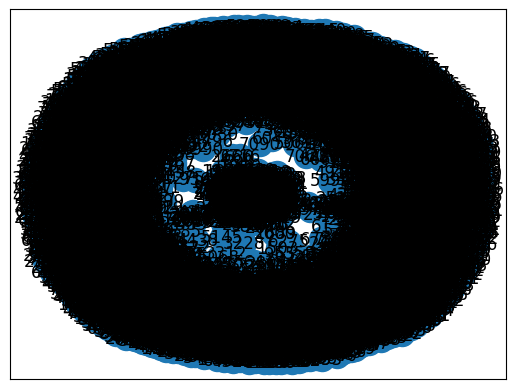

In [49]:
nx.draw_networkx(g1, with_labels=True)

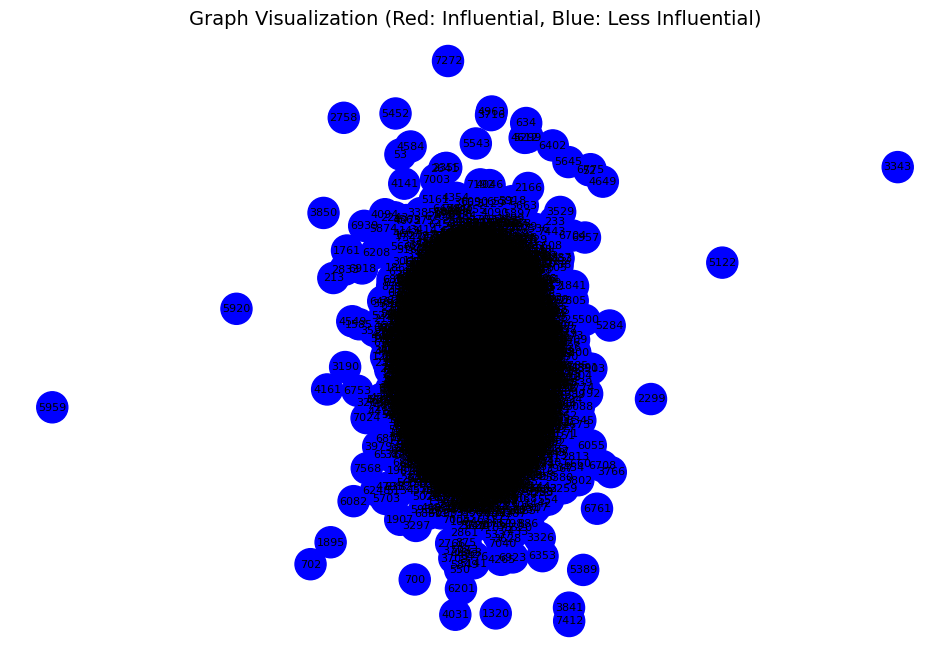

In [50]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a larger figure to give more space to the graph
fig, ax = plt.subplots(figsize=(12, 8))

# Position nodes using the spring layout with adjusted parameters for spacing
pos = nx.spring_layout(g1, k=0.5, iterations=20)

# Generate a color map for node labels
node_colors = ['red' if g1.nodes[node].get('label') == 1 else 'blue' for node in g1.nodes()]

# Draw the graph with the specified node colors and labels
nx.draw(
    g1, pos, ax=ax,
    node_color=node_colors,
    with_labels=True,
    node_size=500,
    font_size=8
)

# Draw the edges more faintly
nx.draw_networkx_edges(g1, pos, ax=ax, alpha=0.5)

# Add title and remove axis
ax.set_title('Graph Visualization (Red: Influential, Blue: Less Influential)', fontsize=14)
plt.axis('off')  # Hide axis ticks and labels
plt.show()


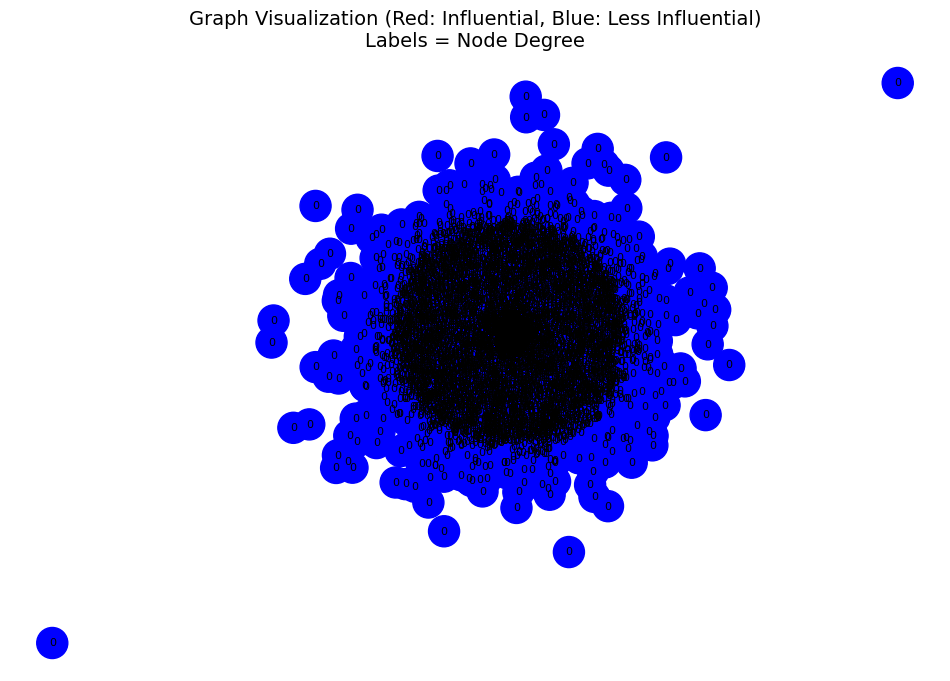

In [51]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate layout for visualization
pos = nx.spring_layout(g1, k=0.5, iterations=20)

# Generate a color map for node labels
node_colors = ['red' if g1.nodes[node].get('label') == 1 else 'blue' for node in g1.nodes()]

# Draw nodes with specified options
nx.draw_networkx_nodes(g1, pos, node_color=node_colors, node_size=500, ax=ax)

# Draw edges more faintly
nx.draw_networkx_edges(g1, pos, alpha=0.5, ax=ax)

# Prepare node labels with degree information
node_labels = {node: str(deg) for node, deg in dict(g1.degree()).items()}
nx.draw_networkx_labels(g1, pos, labels=node_labels, font_size=8, ax=ax)

# Title and axis off
ax.set_title('Graph Visualization (Red: Influential, Blue: Less Influential)\nLabels = Node Degree', fontsize=14)
plt.axis('off')
plt.show()


In [52]:
import networkx as nx

# Check if the graph is strongly connected
if nx.is_strongly_connected(g1):
    print("The directed graph is strongly connected.")
else:
    print("The directed graph is not strongly connected.")

# Check if the graph is weakly connected
if nx.is_weakly_connected(g1):
    print("The directed graph is weakly connected.")
else:
    print("The directed graph is not weakly connected.")


The directed graph is not strongly connected.
The directed graph is not weakly connected.


In [53]:
# Find isolated nodes in the graph
isolated_nodes = [node for node in g1.nodes if g1.degree(node) == 0]

print("Isolated nodes found in the graph:")
print(len(isolated_nodes) )


Isolated nodes found in the graph:
6315


In [54]:
import networkx as nx
import random
import os
import matplotlib.pyplot as plt

In [55]:
import networkx as nx
print(nx.__version__)

3.5


In [56]:
import os
import random
import networkx as nx

# Parameters
num_nodes = 1000  # Number of nodes in the graph
initial_edges = 1  # Number of edges to attach from a new node to existing nodes in the Barabási-Albert graph
num_snapshots = 12  # Number of snapshots to generate
additional_edges_per_step = 50  # Number of edges to add at each step
edges_to_remove_per_snapshot = 100  # Number of edges to randomly remove in each snapshot
output_dir = "/content/barabasi_albert_snapshots_500"  # Directory to save the gpickle files

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Generate the initial Barabási-Albert graph
G = nx.barabasi_albert_graph(num_nodes, initial_edges)

# Save the initial snapshot
initial_snapshot_path = os.path.join(output_dir, f"snapshot_0.gpickle")
#nx.write_gpickle(G, initial_snapshot_path)
pickle.dump(G, open(initial_snapshot_path, "wb"))
print(f"Snapshot 0: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges saved to {initial_snapshot_path}")

# Generate additional snapshots with progressive edge additions and removals
for i in range(1, num_snapshots):
    # Add additional edges
    nodes = list(G.nodes())  # Convert NodeView to a list
    for _ in range(additional_edges_per_step):
        node1, node2 = random.sample(nodes, 2)  # pick 2 random nodes
        if not G.has_edge(node1, node2):  # avoid duplicate edges
            G.add_edge(node1, node2)

    # Remove edges
    edges = list(G.edges())  # Convert EdgeView to a list
    for _ in range(min(edges_to_remove_per_snapshot, len(edges))):  # avoid removing too many
        edge_to_remove = random.choice(edges)
        G.remove_edge(*edge_to_remove)
        edges.remove(edge_to_remove)  # update list

    # Save the graph snapshot
    snapshot_path = os.path.join(output_dir, f"snapshot_{i}.gpickle")
    pickle.dump(G, open(snapshot_path, "wb"))

    # Log snapshot info
    print(f"Snapshot {i}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges saved to {snapshot_path}")

print(f"\n✅ Generated {num_snapshots} snapshots with progressive edge additions/removals, saved to '{output_dir}'")


Snapshot 0: 1000 nodes, 999 edges saved to /content/barabasi_albert_snapshots_500/snapshot_0.gpickle
Snapshot 1: 1000 nodes, 949 edges saved to /content/barabasi_albert_snapshots_500/snapshot_1.gpickle
Snapshot 2: 1000 nodes, 899 edges saved to /content/barabasi_albert_snapshots_500/snapshot_2.gpickle
Snapshot 3: 1000 nodes, 849 edges saved to /content/barabasi_albert_snapshots_500/snapshot_3.gpickle
Snapshot 4: 1000 nodes, 799 edges saved to /content/barabasi_albert_snapshots_500/snapshot_4.gpickle
Snapshot 5: 1000 nodes, 749 edges saved to /content/barabasi_albert_snapshots_500/snapshot_5.gpickle
Snapshot 6: 1000 nodes, 699 edges saved to /content/barabasi_albert_snapshots_500/snapshot_6.gpickle
Snapshot 7: 1000 nodes, 649 edges saved to /content/barabasi_albert_snapshots_500/snapshot_7.gpickle
Snapshot 8: 1000 nodes, 599 edges saved to /content/barabasi_albert_snapshots_500/snapshot_8.gpickle
Snapshot 9: 1000 nodes, 549 edges saved to /content/barabasi_albert_snapshots_500/snapshot_

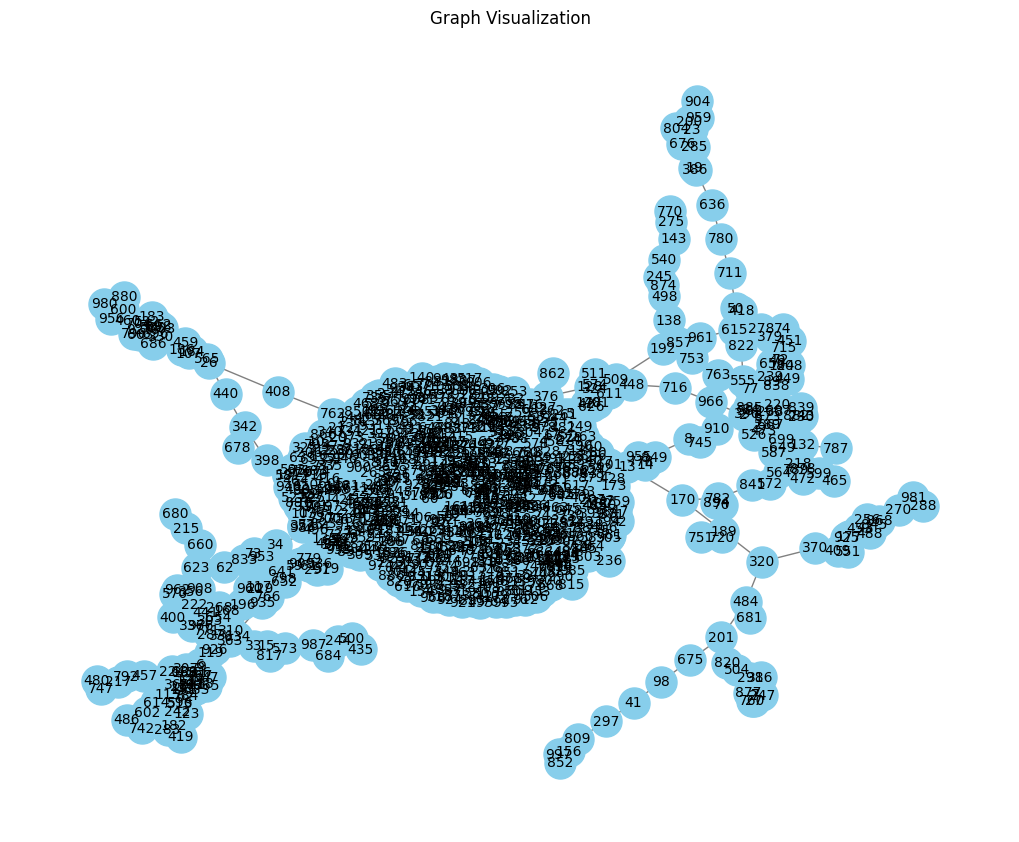


Details of Node 851:
  Features: No features found
  Label: No label found


In [57]:
import os
import pickle
import random
import matplotlib.pyplot as plt
import networkx as nx

# ✅ Change directory path (for Colab, use a folder in /content)
output_dir = "/content/barabasi_albert_snapshots_500"
os.makedirs(output_dir, exist_ok=True)

# ✅ Path to a processed graph file
processed_graph_path = os.path.join(output_dir, "snapshot_9.gpickle")  # replace snapshot_9.gpickle if needed

# ✅ Load the graph using pickle instead of nx.read_gpickle
with open(processed_graph_path, "rb") as f:
    G = pickle.load(f)

# ✅ Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Compute layout for visualization
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray",
        node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

# ✅ Select a random node and print its details
random_node = random.choice(list(G.nodes))
node_data = G.nodes[random_node]

print(f"\nDetails of Node {random_node}:")
print(f"  Features: {node_data.get('features', 'No features found')}")
print(f"  Label: {node_data.get('label', 'No label found')}")


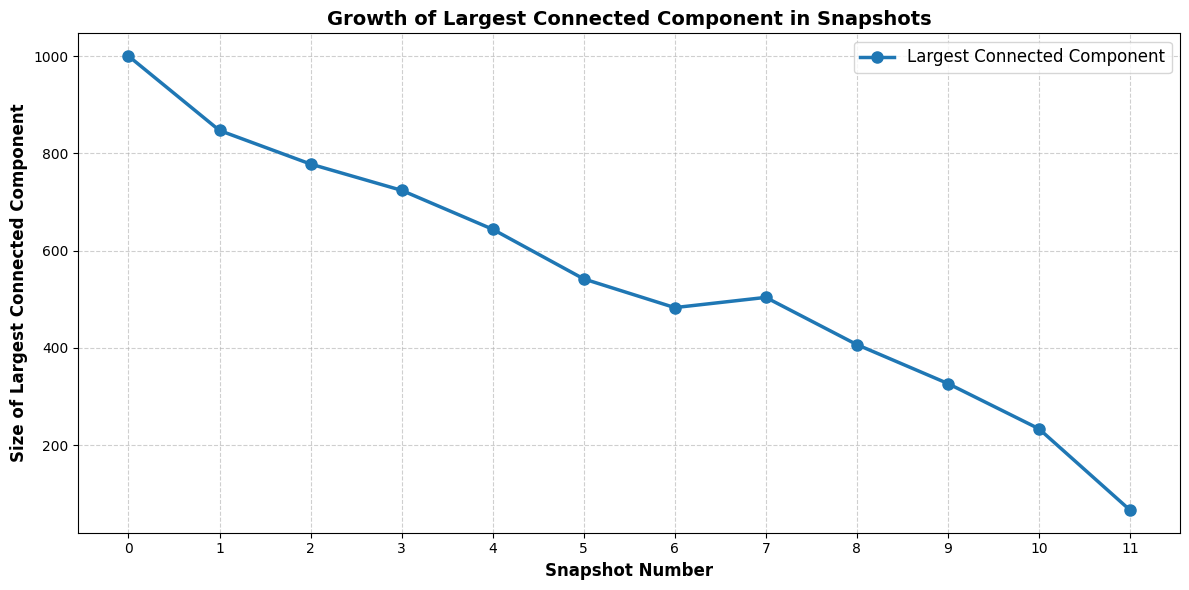

In [58]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle

def plot_connected_components(directory_path, num_snapshots):
    """
    Plot the size of the largest connected component for each snapshot in the directory.

    Parameters:
        directory_path (str): Path to the directory containing graph snapshots.
        num_snapshots (int): Number of snapshots to process.
    """
    largest_components = []
    snapshots = []

    for i in range(num_snapshots):
        snapshot_path = os.path.join(directory_path, f"snapshot_{i}.gpickle")
        if os.path.exists(snapshot_path):
            # Read the graph using pickle (instead of nx.read_gpickle)
            with open(snapshot_path, "rb") as f:
                G = pickle.load(f)

            # If directed, convert to undirected before finding connected components
            if G.is_directed():
                G = G.to_undirected()

            # Compute the size of the largest connected component
            largest_cc = len(max(nx.connected_components(G), key=len))
            largest_components.append(largest_cc)
            snapshots.append(i)
        else:
            print(f"Snapshot {i} not found in {directory_path}")
            break

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(snapshots, largest_components, marker='o', markersize=8, linewidth=2.5, label="Largest Connected Component")
    plt.title("Growth of Largest Connected Component in Snapshots", fontsize=14, fontweight='bold')
    plt.xlabel("Snapshot Number", fontsize=12, fontweight='bold')
    plt.ylabel("Size of Largest Connected Component", fontsize=12, fontweight='bold')
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.xticks(snapshots, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    plt.show()

# Directory containing the graph snapshots
output_dir = "/content/barabasi_albert_snapshots_500"  # adjust path in Colab

# Plot the size of the largest connected component for each snapshot
plot_connected_components(output_dir, num_snapshots=12)


In [59]:
import os
import random
import networkx as nx
import pickle

# Parameters
num_nodes = 1000  # Number of nodes in the graph
initial_edges = 1  # Number of edges to attach from a new node to existing nodes in the Barabási-Albert graph
num_snapshots = 15  # Number of snapshots to generate
edges_to_remove_per_snapshot = 50  # Number of edges to randomly remove in each snapshot (1-10)
additional_edges_per_step_1 = 1    # Number of edges to add in snapshots 1-10
additional_edges_per_step_2 = 200  # Number of edges to add in snapshots 11-15
output_dir = "/content/barabasi_albert_snapshots_1000"  # Directory to save the gpickle files

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Generate the initial Barabási-Albert graph
G = nx.barabasi_albert_graph(num_nodes, initial_edges)

# Save the initial snapshot
initial_snapshot_path = os.path.join(output_dir, f"snapshot_0.gpickle")
with open(initial_snapshot_path, "wb") as f:
    pickle.dump(G, f)

print(f"Snapshot 0: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges saved to {initial_snapshot_path}")

# Generate snapshots
for i in range(1, num_snapshots + 1):
    nodes = list(G.nodes())  # Convert NodeView to a list

    # Determine edge addition count based on snapshot range
    if i <= 10:
        additional_edges_per_step = additional_edges_per_step_1
    else:
        additional_edges_per_step = additional_edges_per_step_2

    # Add additional edges
    for _ in range(additional_edges_per_step):
        node1, node2 = random.sample(nodes, 2)
        if not G.has_edge(node1, node2):  # Avoid duplicate edges
            G.add_edge(node1, node2)

    # Remove edges only for snapshots 1-10
    if i <= 10:
        edges = list(G.edges())
        for _ in range(min(edges_to_remove_per_snapshot, len(edges))):
            edge_to_remove = random.choice(edges)
            G.remove_edge(*edge_to_remove)
            edges.remove(edge_to_remove)

    # Save the graph snapshot
    snapshot_path = os.path.join(output_dir, f"snapshot_{i}.gpickle")
    with open(snapshot_path, "wb") as f:
        pickle.dump(G, f)

    # Log the number of nodes and edges
    print(f"Snapshot {i}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges saved to {snapshot_path}")

print(f"\n✅ Generated {num_snapshots} snapshots with edge removal (1–10) and varying edge additions "
      f"(1–10: {additional_edges_per_step_1}, 11–15: {additional_edges_per_step_2}), saved to '{output_dir}'")


Snapshot 0: 1000 nodes, 999 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_0.gpickle
Snapshot 1: 1000 nodes, 950 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_1.gpickle
Snapshot 2: 1000 nodes, 901 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_2.gpickle
Snapshot 3: 1000 nodes, 852 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_3.gpickle
Snapshot 4: 1000 nodes, 803 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_4.gpickle
Snapshot 5: 1000 nodes, 754 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_5.gpickle
Snapshot 6: 1000 nodes, 705 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_6.gpickle
Snapshot 7: 1000 nodes, 656 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_7.gpickle
Snapshot 8: 1000 nodes, 607 edges saved to /content/barabasi_albert_snapshots_1000/snapshot_8.gpickle
Snapshot 9: 1000 nodes, 558 edges saved to /content/barabasi_albert_snapshots_1000

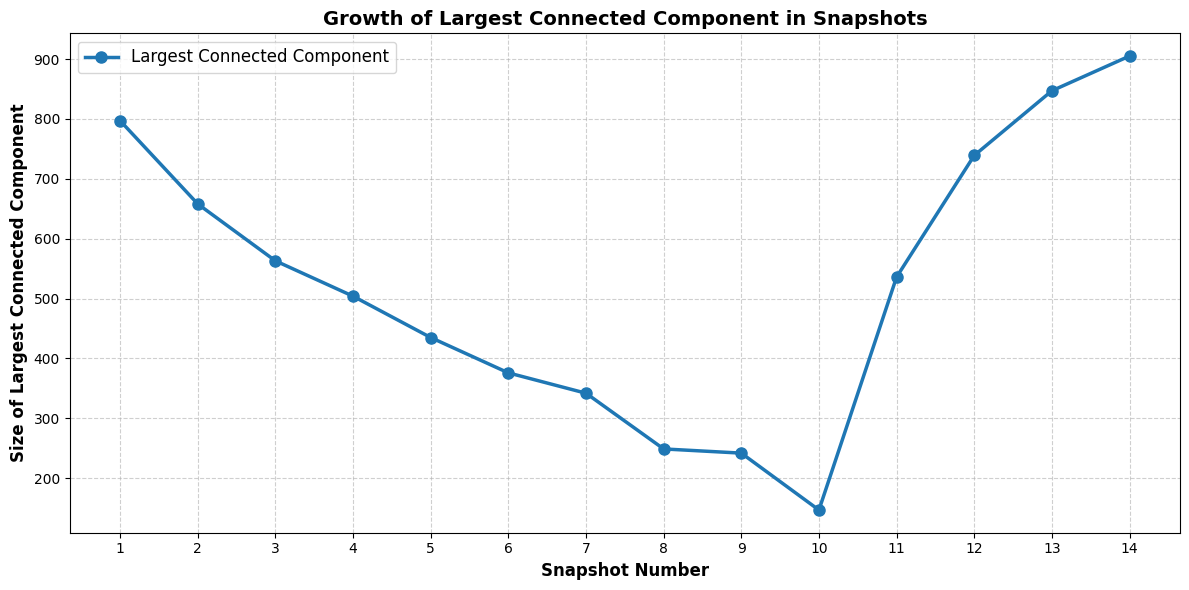

In [60]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle

def plot_connected_components(directory_path, num_snapshots):
    """
    Plot the size of the largest connected component for each snapshot in the directory.

    Parameters:
        directory_path (str): Path to the directory containing graph snapshots.
        num_snapshots (int): Number of snapshots to process.
    """
    largest_components = []
    snapshots = []

    for i in range(1, num_snapshots):
        snapshot_path = os.path.join(directory_path, f"snapshot_{i}.gpickle")
        if os.path.exists(snapshot_path):
            # Read the graph with pickle (instead of nx.read_gpickle)
            with open(snapshot_path, "rb") as f:
                G = pickle.load(f)

            # Convert directed to undirected (if needed)
            if G.is_directed():
                G = G.to_undirected()

            # Compute the size of the largest connected component
            largest_cc = len(max(nx.connected_components(G), key=len))
            largest_components.append(largest_cc)
            snapshots.append(i)
        else:
            print(f"Snapshot {i} not found in {directory_path}")
            break

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(snapshots, largest_components, marker='o', markersize=8, linewidth=2.5, label="Largest Connected Component")
    plt.title("Growth of Largest Connected Component in Snapshots", fontsize=14, fontweight='bold')
    plt.xlabel("Snapshot Number", fontsize=12, fontweight='bold')
    plt.ylabel("Size of Largest Connected Component", fontsize=12, fontweight='bold')
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.xticks(snapshots, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12, loc='best')
    plt.tight_layout()
    plt.show()



# Example: adjust path to your snapshots inside Drive
output_dir = "/content/barabasi_albert_snapshots_1000"

# Plot the size of the largest connected component for each snapshot
plot_connected_components(output_dir, num_snapshots=15)


In [61]:
#Create emailcore daatset
import pandas as pd
import networkx as nx
from datetime import datetime, timedelta
import os
from graphprocessor import GraphProcessor
import numpy as np
from IMutil import IMutil

In [63]:
import os
import urllib.request
import gzip
import shutil

# Base directory in Colab
dir_path = "/content"
dataset_dir = os.path.join(dir_path, "email-Eu-core-temporal-Dept1")
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# File paths
gz_url = "https://snap.stanford.edu/data/email-Eu-core-temporal.txt.gz"
gz_file = os.path.join(dataset_dir, "email-Eu-core-temporal.txt.gz")
txt_file = os.path.join(dataset_dir, "email-Eu-core-temporal-Dept1.txt")

# Step 1: Download gz file if it doesn't exist
if not os.path.exists(gz_file):
    print("Downloading dataset...")
    urllib.request.urlretrieve(gz_url, gz_file)

# Step 2: Extract gz file
if not os.path.exists(txt_file):
    with gzip.open(gz_file, 'rb') as f_in:
        with open(txt_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

print(f"Dataset ready at: {txt_file}")


Dataset ready at: /content/email-Eu-core-temporal-Dept1/email-Eu-core-temporal-Dept1.txt


In [64]:
import pandas as pd
import os

# Base directory and file
dir_path = "/content"
dataset = "/email-Eu-core-temporal-Dept1"
filename = "/email-Eu-core-temporal-Dept1.txt"

# Full file path
file_path = dir_path + dataset + filename

# Load the dataset into a DataFrame
# Columns: source, target, timestamp
df = pd.read_csv(file_path, sep=" ", header=None, names=["SRC", "DST", "timestamp"])

print("Dataset loaded. Number of rows:", len(df))
print(df.head())


Dataset loaded. Number of rows: 332334
   SRC  DST  timestamp
0  582  364          0
1  168  472       2797
2  168  912       3304
3    2  790       4523
4    2  322       7926


In [65]:
# Find the minimum node number
min_node_number = min(df["SRC"].min(), df["DST"].min())
min_node_number

0

In [66]:
# Find the minimum node number
max_node_number = max(df["SRC"].max(), df["DST"].max())
max_node_number

1004

In [67]:
# Get the complete set of nodes
all_nodes = range(max_node_number + 1)
all_nodes

range(0, 1005)

In [68]:
# Convert timestamp to datetime for easy manipulation
df['time'] = pd.to_datetime(df['timestamp'], unit='s')

In [69]:
# Add a 'month' column to group data by year and month
df['month'] = df['time'].dt.to_period('M')

In [70]:
# Group edges by month
monthly_snapshots = df.groupby('month')

# Print the size (number of edges) for each group
group_sizes = monthly_snapshots.size()
print(group_sizes)

month
1970-01    17874
1970-02    16266
1970-03    12142
1970-04    17765
1970-05    19929
1970-06    19085
1970-07    19011
1970-08    28237
1970-09    15070
1970-10    10744
1970-11    19068
1970-12    21661
1971-01    25422
1971-02     5642
1971-03    19557
1971-04    27000
1971-05    28821
1971-06     6616
1972-03     2424
Freq: M, dtype: int64


In [71]:
import os
import networkx as nx
import pickle

# Base directory in Colab
dir_path = "/content"
dataset = "/email-Eu-core-temporal-Dept1"

# Output directory for graphs
output_dir = dir_path + dataset + "/graphs/"
os.makedirs(output_dir, exist_ok=True)

# Assume `monthly_snapshots` is a list of (month, group) tuples
# and `all_nodes` is a list of all node IDs (e.g., 0 to 308)
for i, (month, group) in enumerate(monthly_snapshots):
    # Create a directed graph for the current month
    G = nx.DiGraph()

    # Add all nodes to ensure consistency across snapshots
    G.add_nodes_from(all_nodes)

    # Add edges for the current month's snapshot
    G.add_edges_from(zip(group['SRC'], group['DST']))

    # Save the graph using pickle
    filename = os.path.join(output_dir, f'snapshot_{i}.gpickle')
    with open(filename, 'wb') as f:
        pickle.dump(G, f)

    print(f"Graph for {month} saved as {filename}. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Graph for 1970-01 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_0.gpickle. Nodes: 1005, Edges: 4778
Graph for 1970-02 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_1.gpickle. Nodes: 1005, Edges: 4842
Graph for 1970-03 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_2.gpickle. Nodes: 1005, Edges: 4238
Graph for 1970-04 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_3.gpickle. Nodes: 1005, Edges: 4820
Graph for 1970-05 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_4.gpickle. Nodes: 1005, Edges: 5016
Graph for 1970-06 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_5.gpickle. Nodes: 1005, Edges: 4993
Graph for 1970-07 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_6.gpickle. Nodes: 1005, Edges: 5233
Graph for 1970-08 saved as /content/email-Eu-core-temporal-Dept1/graphs/snapshot_7.gpickle. Nodes: 1005, Edges: 5937
Graph for 1970-09 saved as /content/email-Eu-core-temporal-Dept1

In [72]:
self_loops = [(u, v) for u, v in zip(group['SRC'], group['DST']) if u == v]
print(f"Self-loops: {len(self_loops)}")

Self-loops: 0


In [73]:
duplicates = len(group) - len(set(zip(group['SRC'], group['DST'])))
print(f"Number of duplicate edges: {duplicates}")

Number of duplicate edges: 1069


In [74]:
import networkx as nx

def add_labels_and_features(G, top_percentile=30, uniinfweight=1.0):
    """
    Add IFC scores, labels, and additional features to each node in the graph.

    Parameters:
        G (networkx.Graph): Input graph.
        top_percentile (float): Top percentile for labeling nodes as `1`.
        uniinfweight (float): Weight factor for IFC score calculation.

    Returns:
        networkx.Graph: Graph with added features and labels.
    """
    # Calculate IFC scores (make sure IMutil is imported and available)
    ifc_scores = IMutil.calculate_ifc_score(G, uniinfweight)

    # Sort nodes by IFC score
    sorted_nodes = sorted(ifc_scores.items(), key=lambda x: x[1], reverse=True)

    # Determine the cutoff for top x percentile
    num_top_nodes = int(len(sorted_nodes) * top_percentile / 100)
    top_nodes = {node for node, _ in sorted_nodes[:num_top_nodes]}

    # Add features and labels to nodes
    avg_neighbor_deg = nx.average_neighbor_degree(G)
    for node in G.nodes:
        G.nodes[node]["ifc_score"] = ifc_scores[node]            # IFC score
        G.nodes[node]["label"] = 1 if node in top_nodes else 0  # Label
        G.nodes[node]["features"] = [
            G.degree(node),                  # Node degree
            avg_neighbor_deg[node],          # Average neighbor degree
            G.nodes[node].get("existing_feature", 0),  # Placeholder for other features
        ]

    return G


In [75]:
import os
import networkx as nx
import pickle

def process_and_save_graphs(input_dir, output_dir, top_percentile=30, uniinfweight=1.0):
    """
    Process all graphs in the input directory:
    - Calculate IFC scores
    - Add labels based on top percentile
    - Add features

    Parameters:
        input_dir (str): Directory containing input graphs.
        output_dir (str): Directory to save processed graphs.
        top_percentile (float): Top percentile for labeling nodes as `1`.
        uniinfweight (float): Weight factor for IFC score calculation.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith(".gpickle"):
            # Load graph using pickle
            graph_path = os.path.join(input_dir, file_name)
            with open(graph_path, 'rb') as f:
                G = pickle.load(f)

            # Add features and labels
            G = add_labels_and_features(G, top_percentile, uniinfweight)

            # Save the modified graph using pickle
            output_path = os.path.join(output_dir, file_name)
            with open(output_path, 'wb') as f:
                pickle.dump(G, f)

            print(f"Processed and saved graph: {output_path}")


In [76]:
# Example usage in Colab
input_dir = "/content/email-Eu-core-temporal-Dept1/graphs/"
output_dir = "/content/email-Eu-core-temporal-Dept1/graphs-labels/"

# Call the processing function
process_and_save_graphs(input_dir, output_dir, top_percentile=30, uniinfweight=1.0)


Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_18.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_15.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_10.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_8.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_13.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_16.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_2.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_6.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_4.gpickle
Processed and saved graph: /content/email-Eu-core-temporal-Dept1/graphs-labels/snapshot_7.gpickle
Processed and s

In [ ]:
# ADD FEATURES AND LABELS

In [77]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [78]:
from graphprocessor import GraphProcessor

In [81]:
import os
import networkx as nx
import pickle

# Parameters
num_nodes = 100  # number of nodes in BA graph
m_edges = 3      # edges to attach for each new node
num_snapshots = 10  # how many temporal snapshots to create

# Directories in Colab
input_dir = "/content/barabasi_albert_snapshots_1"
os.makedirs(input_dir, exist_ok=True)

# Initialize a base BA graph
G_prev = nx.barabasi_albert_graph(num_nodes, m_edges)

# Generate snapshots
for i in range(num_snapshots):
    # Copy previous graph
    G = G_prev.copy()

    # Optionally, add/remove edges to simulate temporal changes
    # Example: add 1 random edge
    import random
    u, v = random.sample(range(num_nodes), 2)
    G.add_edge(u, v)

    # Save snapshot as pickle
    snapshot_file = os.path.join(input_dir, f"snapshot_{i}.gpickle")
    with open(snapshot_file, 'wb') as f:
        pickle.dump(G, f)

    # Update previous graph for next snapshot
    G_prev = G

print(f"{num_snapshots} snapshots saved in: {input_dir}")


10 snapshots saved in: /content/barabasi_albert_snapshots_1


In [82]:
output_dir = "/content/barabasi_albert_snapshots_1_labels"
os.makedirs(output_dir, exist_ok=True)


In [83]:
# Make sure the add_labels_and_features function is defined
# Then call:
process_and_save_graphs(input_dir, output_dir, top_percentile=30, uniinfweight=1.0)


Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_8.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_2.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_6.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_4.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_7.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_5.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_1.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_3.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_0.gpickle
Processed and saved graph: /content/barabasi_albert_snapshots_1_labels/snapshot_9.gpickle


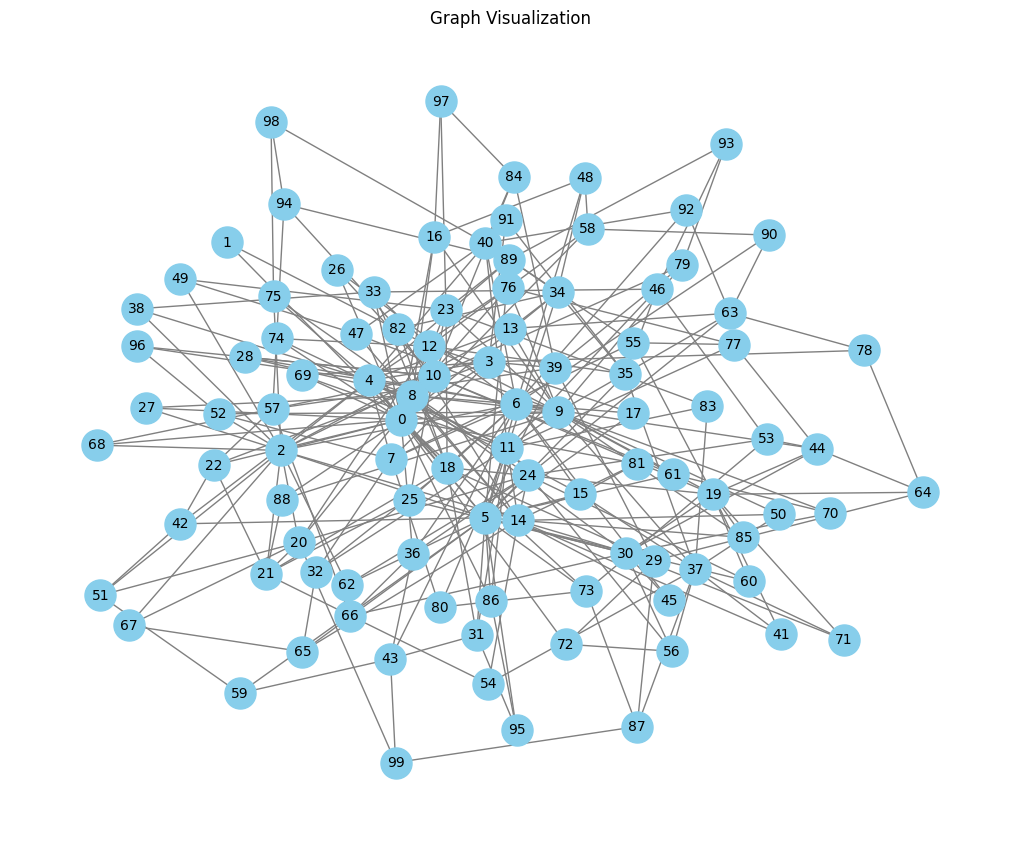


Details of Node 58:
  Features: [4, 10.5, 0]
  Label: 0


In [84]:
import os
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random

# Path to a processed graph file
processed_graph_path = "/content/barabasi_albert_snapshots_1_labels/snapshot_0.gpickle"  # Adjust if needed

# Load the graph using pickle
with open(processed_graph_path, 'rb') as f:
    G = pickle.load(f)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Compute layout for visualization
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

# Select a random node and print its details
random_node = random.choice(list(G.nodes))
node_data = G.nodes[random_node]

print(f"\nDetails of Node {random_node}:")
print(f"  Features: {node_data.get('features', 'No features found')}")
print(f"  Label: {node_data.get('label', 'No label found')}")


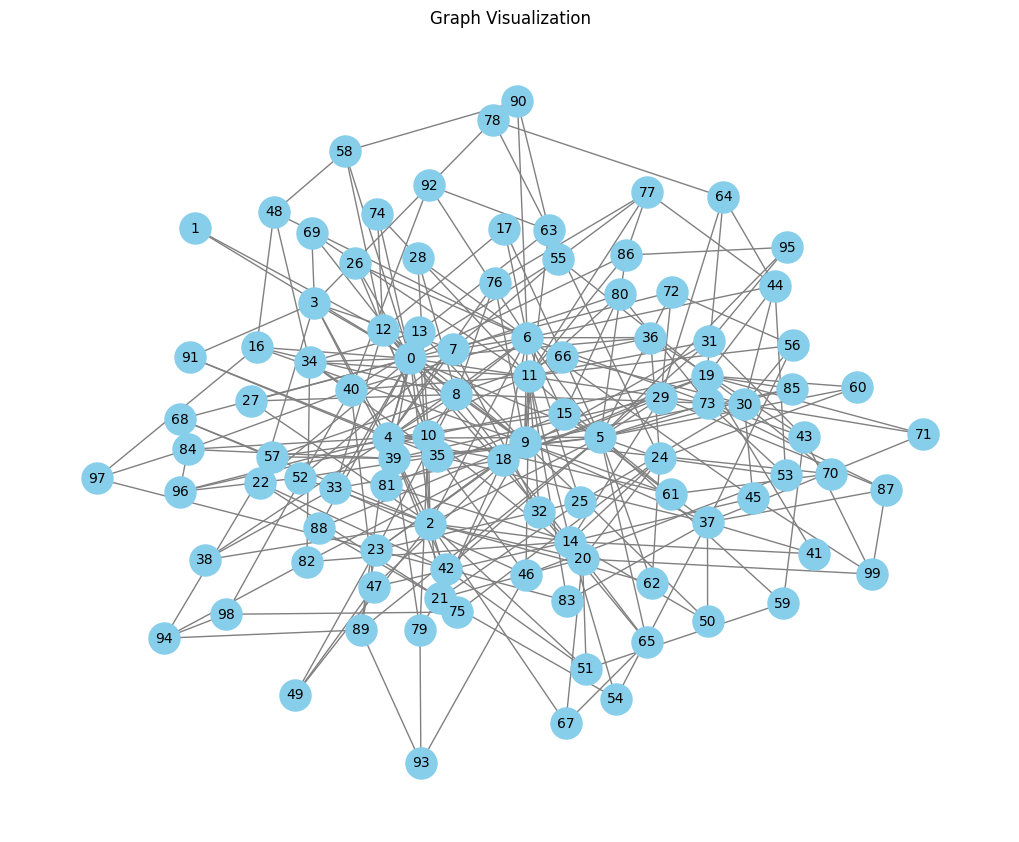


Details of Node 49:
  Features: [3, 10.0, 0]
  Label: 0


In [87]:
import os
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random

# Path to a processed graph file (snapshot 19)
processed_graph_path = "/content/barabasi_albert_snapshots_1_labels/snapshot_5.gpickle"  # Adjust if needed

# Load the graph using pickle
with open(processed_graph_path, 'rb') as f:
    G = pickle.load(f)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Compute layout for visualization
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

# Select a random node and print its details
random_node = random.choice(list(G.nodes))
node_data = G.nodes[random_node]

print(f"\nDetails of Node {random_node}:")
print(f"  Features: {node_data.get('features', 'No features found')}")
print(f"  Label: {node_data.get('label', 'No label found')}")


In [88]:
import os
import networkx as nx
import pickle

# Path to a processed graph file (snapshot 1)
processed_graph_path = "/content/barabasi_albert_snapshots_1_labels/snapshot_1.gpickle"

# Load the graph using pickle
with open(processed_graph_path, 'rb') as f:
    G = pickle.load(f)

# Find nodes with label 1
nodes_with_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]

# Count and print
count_label_1 = len(nodes_with_label_1)
print(f"\nNumber of nodes with label 1: {count_label_1}")

# Print details of the first few nodes with label 1
if nodes_with_label_1:
    for node in nodes_with_label_1[:5]:
        print(f"\nNode {node}:")
        print(f"  Features: {G.nodes[node].get('features', 'No features found')}")
        print(f"  Label: {G.nodes[node].get('label')}")
else:
    print("No nodes with label 1 found.")



Number of nodes with label 1: 30

Node 0:
  Features: [26, 7.653846153846154, 0]
  Label: 1

Node 2:
  Features: [18, 9.055555555555555, 0]
  Label: 1

Node 3:
  Features: [8, 8.875, 0]
  Label: 1

Node 4:
  Features: [18, 9.88888888888889, 0]
  Label: 1

Node 5:
  Features: [24, 7.666666666666667, 0]
  Label: 1


In [ ]:
# INFLUENCE MAXIMIZATION COMPARISON

In [89]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from influencemaximization import InfluenceMaximization
from graphprocessor import GraphProcessor
import random

In [95]:
import networkx as nx
import pickle

# Directory where labeled graphs are saved
graph_dir = "/content/barabasi_albert_snapshots_1_labels"

# Load the sample graph (snapshot 14)
graph_path = graph_dir + "/snapshot_9.gpickle"

# Load the graph using pickle
with open(graph_path, 'rb') as f:
    G = pickle.load(f)

# Optional: check basic info
print(f"Graph loaded. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Graph loaded. Nodes: 100, Edges: 299


In [96]:
# Initialize the Influence Maximization class
inf_max = InfluenceMaximization(graph=G, propagation_probability=0.01, monte_carlo=100)

# Run the greedy algorithm for different k values
for k in [5, 10, 20]:
    seed_set, spread, timelapse = inf_max.greedy(k=k)
    print(f"Greedy Algorithm for k={k}:")
    print(f"Seed Set: {seed_set}")
    print(f"Spread: {spread[-1]}")
    print(f"Time: {timelapse[-1]:.2f} seconds")

Greedy Algorithm for k=5:
Seed Set: [0, 9, 2, 5, 4]
Spread: 6.39
Time: 4.38 seconds
Greedy Algorithm for k=10:
Seed Set: [0, 9, 2, 5, 4, 18, 34, 6, 14, 22]
Spread: 11.86
Time: 11.10 seconds
Greedy Algorithm for k=20:
Seed Set: [0, 9, 2, 5, 4, 18, 34, 6, 14, 22, 11, 30, 39, 16, 19, 87, 33, 63, 23, 37]
Spread: 22.23
Time: 39.77 seconds


In [97]:
G = nx.erdos_renyi_graph(1000, 0.01, seed=None, directed=True)
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 1000
Number of Edges: 10058


In [98]:
# Initialize GraphProcessor
graph_processor = GraphProcessor()
G = graph_processor.add_features_to_graph(G)
# Add labels based on IFC score (top 30% of nodes)
G = graph_processor.add_labels_to_graph(G, top_percentage=30)

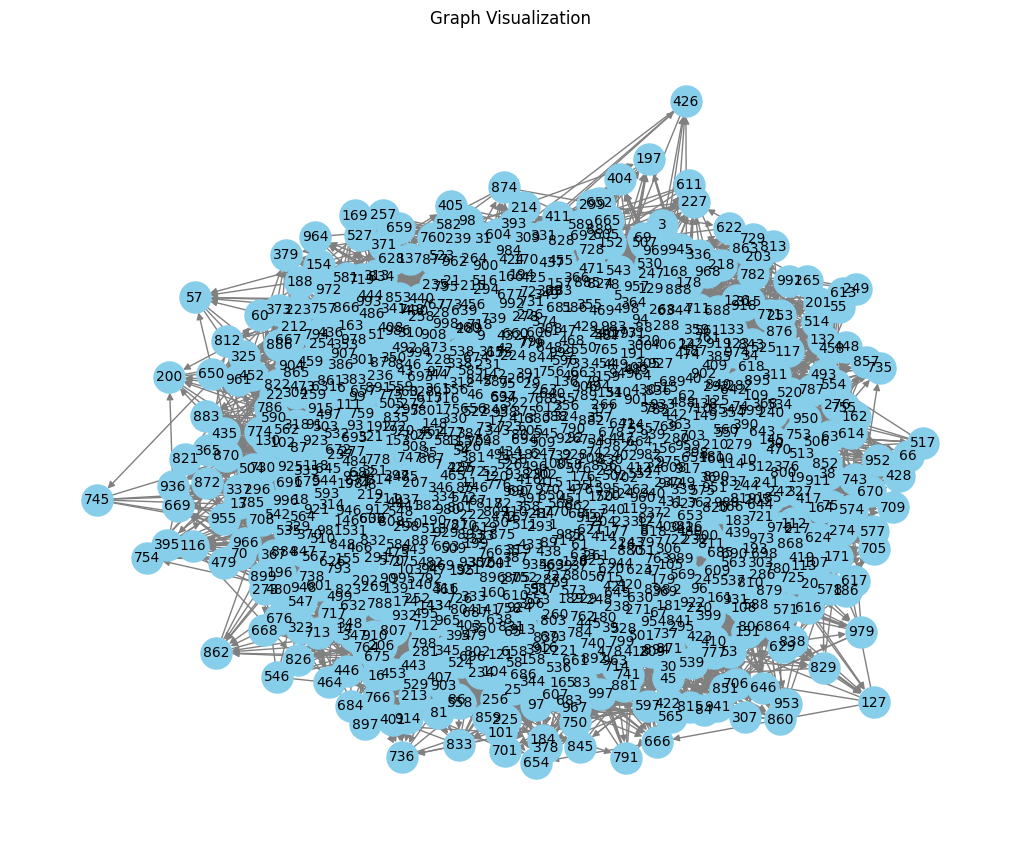

<bound method Graph.number_of_nodes of <networkx.classes.digraph.DiGraph object at 0x7e5510eead10>> <bound method Graph.number_of_edges of <networkx.classes.digraph.DiGraph object at 0x7e5510eead10>>

Details of Node 498:
  Features: [21, 0.0026494287268625503, 14, 10.75, 273.0]
  Label: 1


In [99]:
# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Compute layout for visualization
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

print(G.number_of_nodes, G.number_of_edges)

# Select a random node and print its details
random_node = random.choice(list(G.nodes))
node_data = G.nodes[random_node]
# Find and print nodes with label 1
nodes_with_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]

print(f"\nDetails of Node {random_node}:")
print(f"  Features: {node_data.get('features', 'No features found')}")
print(f"  Label: {node_data.get('label', 'No label found')}")